In [ ]:
import numpy as np # for loading nd exploring data set
import pandas as pd # working with numerical arrays and math operations
import matplotlib.pyplot as plt
import seaborn as sb # Matplotlib and Seaborn: Used to plot data distributions, trends and model performance.
from sklearn.model_selection import train_test_split # splits data into training and validation set
from sklearn.preprocessing import LabelEncoder, StandardScaler # label encoder converts converts categories like genre into numeric format, standard scaler scales features for better model performance
from sklearn.feature_extraction.text import CountVectorizer # converts text data into numeric vectors
from sklearn import metrics # offers tools for evaluating model accuracy
from xgboost import XGBRegressor # high performance algorithm for better predictions

import warnings
warnings.filterwarnings('ignore') # hides unnecessary warnings for a cleaner output

In [ ]:
df = pd.read_csv('boxoffice.csv',
                 encoding='latin-1') # load and print dataset into a pandas dataframe
df.head()

title  domestic_revenue  world_revenue   distributor  \
0   The Avengers           6026491     1274885664  Warner Bros.   
1        Titanic         169411543     1132871091        Disney   
2  Jurassic Park         107836098      583329845          Sony   
3         Avatar          51433697     1225323391        Disney   
4  The Lion King         142791649      604140729  Warner Bros.   

   opening_revenue  opening_theaters     budget   MPAA     genres  \
0        163620146               253  174687337      R  Animation   
1         85549990               122  103948486      G     Action   
2         55681429              3826  122104991  NC-17     Horror   
3        109775324              3868   46431596      G     Horror   
4         59476800              2934  203513696      R     Comedy   

   release_days  
0            16  
1           103  
2            89  
3            85  
4           158

In [ ]:
df.shape # numbr of rows and columns

(2694, 10)

In [ ]:
df.info() # chck the datatype of each column and look for issues

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             2694 non-null   object
 1   domestic_revenue  2694 non-null   int64 
 2   world_revenue     2694 non-null   int64 
 3   distributor       2694 non-null   object
 4   opening_revenue   2694 non-null   int64 
 5   opening_theaters  2694 non-null   int64 
 6   budget            2694 non-null   int64 
 7   MPAA              2694 non-null   object
 8   genres            2694 non-null   object
 9   release_days      2694 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 210.6+ KB


In [ ]:
df.describe().T # describe gives a summary of the numeric columns and T transposes the output for better readability (rows and columns switch)

count          mean           std        min           25%  \
domestic_revenue  2694.0  1.508539e+08  8.579997e+07   827765.0  7.673272e+07   
world_revenue     2694.0  7.719177e+08  4.284414e+08  3261301.0  3.991135e+08   
opening_revenue   2694.0  9.971321e+07  5.721762e+07   138569.0  5.033848e+07   
opening_theaters  2694.0  2.263039e+03  1.298559e+03       10.0  1.161000e+03   
budget            2694.0  1.537996e+08  8.557624e+07  5197977.0  7.861876e+07   
release_days      2694.0  9.089755e+01  5.089404e+01        1.0  4.700000e+01   

                          50%           75%           max  
domestic_revenue  152572473.5  2.247314e+08  2.998107e+08  
world_revenue     766555142.5  1.143920e+09  1.499310e+09  
opening_revenue    99814175.0  1.489805e+08  1.999336e+08  
opening_theaters       2271.5  3.392250e+03  4.499000e+03  
budget            156256716.0  2.274832e+08  2.998597e+08  
release_days             91.0  1.350000e+02  1.790000e+02

In [ ]:
to_remove = ['world_revenue', 'opening_revenue']
df.drop(to_remove, axis=1, inplace=True) # only predicting domestic revenue so we are removing extra information

In [ ]:
df.isnull().sum() * 100 / df.shape[0] # We calculate what percentage of values is missing in each column. isnull().sum() functions helps us identify columns with many missing entries.

title               0.0
domestic_revenue    0.0
distributor         0.0
opening_theaters    0.0
budget              0.0
MPAA                0.0
genres              0.0
release_days        0.0
dtype: float64

In [ ]:
#df.drop("budget", axis = 1,  inplace=True) #We drop the budget column entirely, likely due to too many missing values.

for col in ['MPAA']:#'genres']:
    df[col] = df[col].fillna(df[col].mode()[0]) # Fill missing values in MPAA and genres columns using their most frequent values (mode).

df.dropna(inplace=True) # Remove any remaining rows with missing values.

df.isnull().sum().sum() # Finally, check if any null values remain; the result should be 0.

np.int64(0)

In [ ]:
print(df.columns)


Index(['title', 'domestic_revenue', 'distributor', 'opening_theaters',
       'budget', 'MPAA', 'genres', 'release_days'],
      dtype='object')


In [ ]:
df['domestic_revenue'] = df['domestic_revenue'].astype(str).str[1:] # Remove the first character from 'domestic_revenue' (likely a $ sign).

for col in ['domestic_revenue', 'opening_theaters', 'release_days']:
    df[col] = df[col].astype(str).str.replace(',', '')  # Remove commas from numeric values (e.g., 1,000 to 1000).

    temp = (~df[col].isnull())
    df[temp][col] = df[temp][col].convert_dtypes(float) # ensure the columns are correctly converted to float type

    df[col] = pd.to_numeric(df[col], errors='coerce') #use pd.to_numeric to handl any remaining non numeric values gracefully to turn them into NaNs

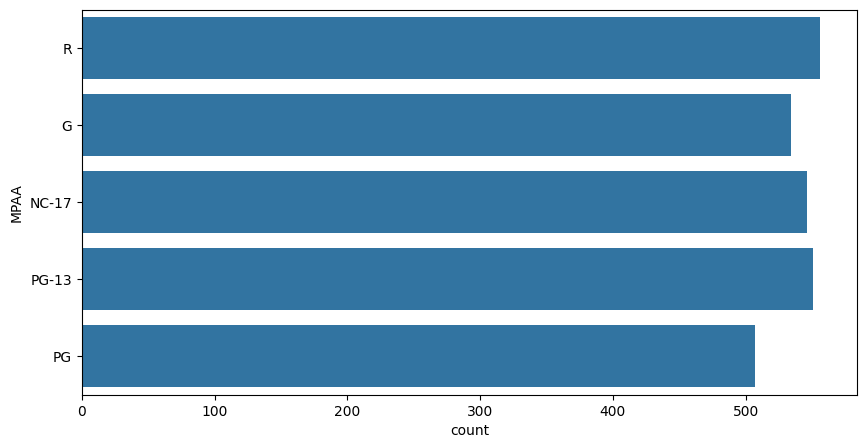

In [ ]:
plt.figure(figsize=(10, 5)) # sets the size of the plot
sb.countplot(df['MPAA']) # from seaborn, automatically counts and plots the frequency of each category in the 'MPAA' column
plt.show() # displays the plot

In [ ]:
df.groupby('MPAA')['domestic_revenue'].mean() # We group the dataset by the 'MPAA' rating category and calculate the mean (average) of the 'domestic_revenue' for each rating group.

MPAA
G        3.426099e+07
NC-17    3.452006e+07
PG       3.697347e+07
PG-13    3.510989e+07
R        3.670206e+07
Name: domestic_revenue, dtype: float64

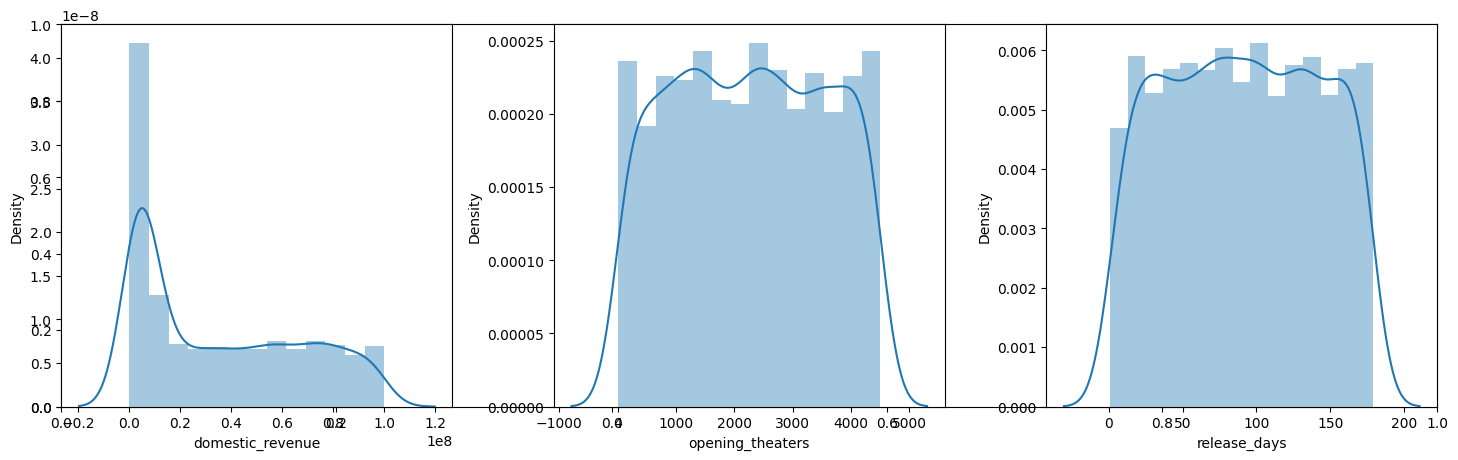

In [ ]:
plt.subplots(figsize=(15, 5))

features = ['domestic_revenue', 'opening_theaters', 'release_days'] # three side by side plots in one row
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1) # for each feature, we show the distribution using Seaborn's distplot
    sb.distplot(df[col])
plt.tight_layout()
plt.show() # This helps check if the data is normally distributed, skewed or has any unusual patterns.

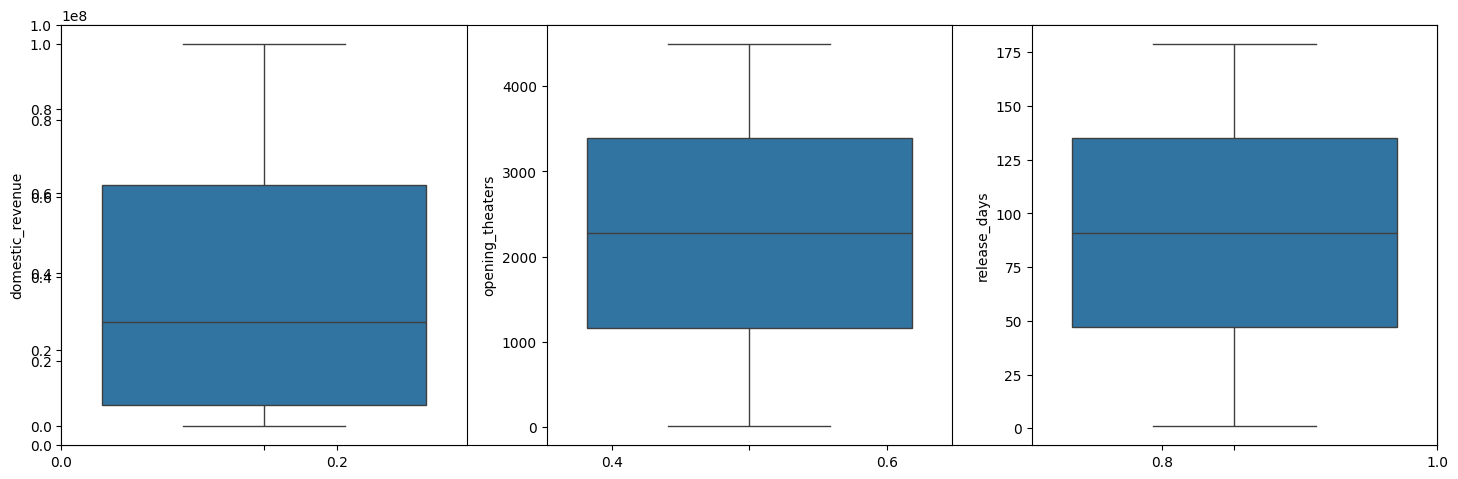

In [ ]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features): #creating three boxplots, one for each feature side by side, this helps us identify unusual values that might affect the model
    plt.subplot(1, 3, i+1)
    sb.boxplot(df[col])
plt.tight_layout()
plt.show()

In [ ]:
for col in features:
  df[col] = df[col].apply(lambda x: np.log10(x)) # taking base 10 log of each value in the specified columns. This helps make skewed data more normally distributed and reduces the effect of extreme values.

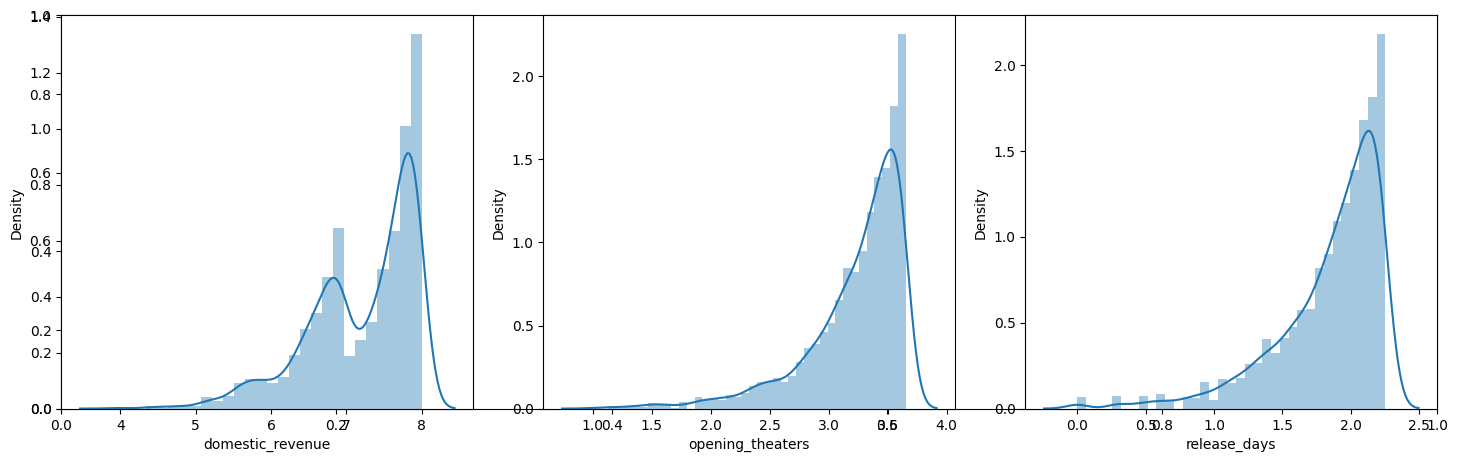

In [ ]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sb.distplot(df[col])
plt.tight_layout()
plt.show() # We visualize the distributions of the numeric features again to see the effect of the log transformation.

In [ ]:
vectorizer = CountVectorizer() #We use CountVectorizer to convert each genre like “Action”, “Comedy” into a binary feature i.e 1 if the movie belongs to that genre, else 0.
vectorizer.fit(df['genres'])
features = vectorizer.transform(df['genres']).toarray()

genres = vectorizer.get_feature_names_out()
for i, name in enumerate(genres):
	df[name] = features[:, i]

df.drop('genres', axis=1, inplace=True) #Then drop the original genres text column since it’s now represented numerically.

In [ ]:
removed = 0 #We will check for columns between 'action' and 'western' in the DataFrame and drop columns where over 95% of values are zero meaning that genre is rare.

if 'action' in df.columns and 'western' in df.columns:
    for col in df.loc[:, 'action':'western'].columns:

        if (df[col] == 0).mean() > 0.95:
            removed += 1
            df.drop(col, axis=1, inplace=True)

print(removed)
print(df.shape)

0
(2694, 13)


In [ ]:
for col in ['distributor', 'MPAA']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col]) # We use LabelEncoder to replace each unique category with a number like “PG” to 0, “R” to 1. This is necessary because machine learning models work better with numbers than text labels.

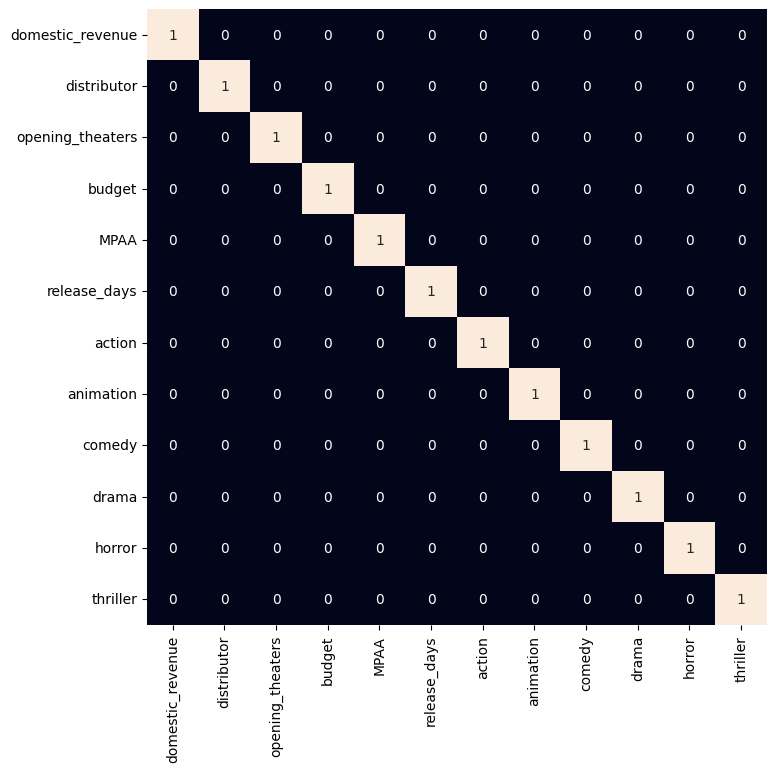

In [ ]:
plt.figure(figsize=(8, 8))
sb.heatmap(df.select_dtypes(include=np.number).corr() > 0.8,  # We will calculate the correlation matrix for all numeric columns.
            annot=True,
            cbar=False)
plt.show() # Then plot a heatmap, highlighting pairs of features with correlation greater than 0.8 (very strong correlation). This helps us identify redundant features that may need to be removed or handled before modeling.

In [ ]:
features = df.drop(['title', 'domestic_revenue'], axis=1)
target = df['domestic_revenue'].values # We will remove the title and target column domestic_revenue from the features and set domestic_revenue as the target variable.

X_train, X_val, Y_train, Y_val = train_test_split(features, target,
									test_size=0.1,
									random_state=22)  # We split the data into 90% training and 10% validation sets to evaluate model performance.
X_train.shape, X_val.shape

((2424, 11), (270, 11))

In [ ]:
scaler = StandardScaler() # We scale the features to have a mean of 0 and a standard deviation of 1, which helps models learn more effectively.
X_train = scaler.fit_transform(X_train) # fit_transform learns scaling parameters from training data and applies scaling.
X_val = scaler.transform(X_val) # transform applies the same scaling to validation data without changing the scaler.

In [ ]:
from sklearn.metrics import mean_absolute_error as mae
model = XGBRegressor() #initializing an XGBoost regressor, a gradient boosting model
model.fit(X_train, Y_train) # then train the model on the normalized training data (X_train) and target value (Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
train_preds = model.predict(X_train)
print('Training Error : ', mae(Y_train, train_preds)) # we use Mean Absolute Error to check how well the model predicts revenue on both training and validation data

val_preds = model.predict(X_val) # We predict revenue for the training data and calculate MAE to measure training error.
print('Validation Error : ', mae(Y_val, val_preds)) # Also we predict revenue for the validation data and calculate MAE to measure how well the model generalizes.
print()

Training Error :  0.17876891076956283
Validation Error :  0.5939063916822717

